In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
from sklearn.metrics import make_scorer, roc_auc_score
import pandas as pd
import numpy as np
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from plot_metric.functions import BinaryClassification
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict, TimeSeriesSplit, StratifiedKFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import confusion_matrix
# пайплайн
from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
# дамми-регрессор
from sklearn.dummy import DummyClassifier
from itertools import combinations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
import shutil
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y,\
                                                cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]

class SklearnHelperLogitSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, early_stopping, pval=.05):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.early_stopping = early_stopping
        self.pVal = pval
    def fit(self, X, y=None):
        #####################################################################################################
        def calc_vif(X): 
            _X = pd.DataFrame(X)
            vif = pd.DataFrame()
            vif["variables"] = _X.columns
            vif["VIF"] = [variance_inflation_factor(_X.values, i) for i in tqdm_notebook(range(_X.shape[1]))]
            return(vif)
        ######################################################################################################
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
        
        early_stopping_counter = 0    
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

            else:
                to_drop_before.append(i)
        
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    sm_logit = sm.Logit(y, _X_curr).fit()
                    pVals = np.array(sm_logit.pvalues)
                    if np.all(pVals<=self.pVal):
                        vif = calc_vif(_X_curr)
                        if (vif['VIF']<=10).all():
                            best_cv_score = mean_cv_score
                            best_features = curr_features
                            early_stopping_counter=0
                        else:
                            early_stopping_counter += 1
                            if early_stopping_counter == self.early_stopping:
                                break

                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
    
class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'}) 
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                  
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr.fillna(self.y_mean) 
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc.fillna(self.y_mean)
def convert_types(df):
    '''конвертирует типы (по возможности)'''
    df_c = df.copy()
    for col in df.columns:
        ser = df[col]
        try:
            ser2 = ser.astype('datetime64')
            df_c[col] = ser2
        except:
            try:
                ser_float =ser.astype(np.float32)
                ser_int =ser.astype(np.int32)
                if (ser_float == ser_int).all():
                    df_c[col] =ser_int
                else:
                    df_c[col] =ser_float
            except:
                try:
                    df_c[col] = ser.str.lower().str.strip()
                except:
                    df_c[col] = ser
    return df_c
def get_diff(y_tr, df_buffer_table2_tr, feature):
    '''значения признаков для таргета0 и таргета1'''
    cash_hist_target1 = y_tr[y_tr['target']==1]['cash_hist'].unique()
    df_buffer_table2_target1_tr = df_buffer_table2_tr[df_buffer_table2_tr['cash_hist'].isin(cash_hist_target1)]
    df_buffer_table2_target0_tr = df_buffer_table2_tr[~df_buffer_table2_tr['cash_hist'].isin(cash_hist_target1)]
    df_diff= df_buffer_table2_target1_tr[feature].value_counts(normalize = True).to_frame('target1')\
                .join(df_buffer_table2_target0_tr[feature].value_counts(normalize = True).to_frame('target0'))
    return (df_diff['target1']-df_diff['target0']).abs().sort_values(ascending = False)

def add_features(X_tr, df_features):
    return pd.merge(X_tr, df_features, on =IDX_COLUMN, how='left')
class SklearnHelperVIF(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, treshold):
        self.treshold= treshold
    def fit(self, X, y=None):
        try:
            _X = X.toarray()
        except:
            _X=X
        _X = pd.DataFrame(_X)
        vif = pd.DataFrame()
        vif["variables"] = _X.columns
        vif["VIF"] = [variance_inflation_factor(_X.values, i) for i in tqdm_notebook(range(_X.shape[1]))]
        self.to_use = vif[vif["VIF"]<=self.treshold]['variables']
        return self
    def transform(self,X):
        try:
            _X = X.toarray()
        except:
            _X=X
        _X = pd.DataFrame(_X)        
        return _X[self.to_use].values     
    
class SklearnHelperColumnSelector(BaseEstimator, TransformerMixin):
    '''выбирает колонки, отпавляемые в пайплайн'''
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        return X[self.columns]

In [3]:
# данные
X_tr = pd.read_pickle('X_tr.pickle')
X_te = pd.read_pickle('X_te.pickle')
y_tr = pd.read_pickle('y_tr.pickle')
y_te = pd.read_pickle('y_te.pickle')

In [4]:
# константы
SEED = 13
N_FOLDS = 10
EARLY_STOPPING = 10

In [5]:
# пайплайн отбора признаков
logit = LogisticRegression(random_state= SEED)
SKF = StratifiedKFold(N_FOLDS, shuffle = True, random_state = SEED)
ppl = make_pipeline(MinMaxScaler(),\
                    SimpleImputer(strategy='constant', fill_value=-1),\
                    SklearnHelperFeatureSelector(model=logit, cv=SKF, scoring='roc_auc', show_progress = True))
# фитим пайплайн
ppl.fit(X_tr, y_tr)
_x_tr = ppl.transform(X_tr)
_x_te = ppl.transform(X_te)

new best score = 0.6544282709
new best score = 0.6782816376
new best score = 0.6800942959
new best score = 0.6986165850
new best score = 0.7173405635
new best score = 0.7306514060
new best score = 0.7314899155
new best score = 0.7343268639
new best score = 0.7391121761
new best score = 0.7400352245
new best score = 0.7408024912
new best score = 0.7437001647
new best score = 0.7438665965
new best score = 0.7440125882
new best score = 0.7503864777
new best score = 0.7505252591
new best score = 0.7513166042
new best score = 0.7521541214
new best score = 0.7527366329
new best score = 0.7529446727
new best score = 0.7532223678
new best score = 0.7532402942
new best score = 0.7534024925
new best score = 0.7541621520
new best score = 0.7543508761
new best score = 0.7555160313
new best score = 0.7555164943
new best score = 0.7556144616
new best score = 0.7561321466
new best score = 0.7561344618
new best score = 0.7574653212
new best score = 0.7578081073
new best score = 0.7584716517
new best s

new best score = 0.8306250124
new best score = 0.8307544667
new best score = 0.8310408935
new best score = 0.8313887731
new best score = 0.8314346808
new best score = 0.8314465215
new best score = 0.8316200975
new best score = 0.8316848577
new best score = 0.8317194539
new best score = 0.8317721088



new best score = 0.8320230134
new best score = 0.8322745133
new best score = 0.8326052602
new best score = 0.8327443062
new best score = 0.8327595205
new best score = 0.8327892216
new best score = 0.8328284482
new best score = 0.8330821311
new best score = 0.8334276293
new best score = 0.8338757252



new best score = 0.8340230398
new best score = 0.8341262990



In [11]:
# with open('_x_tr.pickle', 'wb') as f:
#     pickle.dump(_x_tr, f)
# with open('_x_te.pickle', 'wb') as f:
#     pickle.dump(_x_te, f)

In [159]:
vif = SklearnHelperVIF(treshold=10)
vif.fit(_x_tr)
_x2_tr = vif.transform(_x_tr)
_x2_te = vif.transform(_x_te)

In [160]:
_x2_tr_c=  _x2_tr.copy()
_x2_te_c=  _x2_te.copy()

sm_logit = sm.Logit(_y_tr, _x2_tr_c).fit()
pVals = pd.Series(sm_logit.pvalues).sort_values(ascending = False)
while True:
    if pVals.iloc[0] >= .05:
        _x2_tr_c = np.delete(_x2_tr_c, pVals.index[0], axis = 1)
        _x2_te_c = np.delete(_x2_te_c, pVals.index[0], axis = 1)
        sm_logit = sm.Logit(_y_tr, _x2_tr_c).fit()
        pVals = pd.Series(sm_logit.pvalues).sort_values(ascending = False)
    else:
        break

Optimization terminated successfully.
         Current function value: 0.263077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263077
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263078
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263080
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263085
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263089
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263095
  

In [161]:
_y_tr = y_tr.values
gs = GridSearchCV(logit,\
                  param_grid={'C':np.logspace(-3, 3, 100)},\
                  cv = SKF,\
                  scoring = 'roc_auc',\
                  verbose = 1, n_jobs=-1)
gs.fit(_x2_tr_c, _y_tr)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=13, shuffle=True),
             estimator=LogisticRegression(random_state=13), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6....
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='roc_auc', verbose=1)

In [162]:
GINI_best_cv = 100*((2 *gs.best_score_)-1)

In [163]:
GINI_best_cv

52.409246360130425

In [164]:
sm_logit = sm.Logit(_y_tr, _x2_tr_c).fit()

Optimization terminated successfully.
         Current function value: 0.269988
         Iterations 8


In [165]:
sm_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5632
Model:                          Logit   Df Residuals:                     5587
Method:                           MLE   Df Model:                           44
Date:                Sun, 11 Jul 2021   Pseudo R-squ.:                  0.1476
Time:                        16:47:04   Log-Likelihood:                -1520.6
converged:                       True   LL-Null:                       -1783.8
Covariance Type:            nonrobust   LLR p-value:                 6.635e-84
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6338      0.106      5.991      0.000       0.426       0.841
x2             0.4697      0.154      3.044      0.002       0.167       0.772
x3             1.3913      0.368      3.778      0.000       0.670       2.113
x4             1.4082      0.503      2.801      0.005       0.423       2.394
x5             0.3782      0.105      3.606      0.000       0.173       0.584
x6             1.1726      0.380      3.085      0.002       0.428       1.918
x7             0.4680      0.106      4.431      0.000       0.261       0.675
x8            -0.4493      0.163     -2.752      0.006      -0.769      -0.129
x9             0.4132      0.136      3.049      0.002       0.148       0.679
x10            0.4825      0.187      2.581      0.010       0.116       0.849
x11           -0.6393      0.126     -5.093      0.000      -0.885      -0.393
x12           -0.5569      0.124     -4.499      0.000      -0.800      -0.314
x13            0.3081      0.101      3.038      0.002       0.109       0.507
x14            0.3816      0.105      3.651      0.000       0.177       0.586
x15            0.3758      0.103      3.655      0.000       0.174       0.577
x16            0.6655      0.113      5.867      0.000       0.443       0.888
x17            0.7481      0.336      2.228      0.026       0.090       1.406
x18           -0.3456      0.112     -3.073      0.002      -0.566      -0.125
x19           -9.1883      1.341     -6.851      0.000     -11.817      -6.560
x20            0.4027      0.194      2.073      0.038       0.022       0.784
x21            0.3212      0.100      3.209      0.001       0.125       0.517
x22           -1.0099      0.343     -2.942      0.003      -1.683      -0.337
x23            0.5101      0.218      2.341      0.019       0.083       0.937
x24           -0.5731      0.172     -3.331      0.001      -0.910      -0.236
x25            0.3774      0.118      3.189      0.001       0.145       0.609
x26           -0.2209      0.102     -2.159      0.031      -0.421      -0.020
x27            0.3362      0.140      2.403      0.016       0.062       0.610
x28            0.3376      0.111      3.035      0.002       0.120       0.556
x29           -0.5781      0.138     -4.175      0.000      -0.850      -0.307
x30           -0.2288      0.102     -2.244      0.025      -0.429      -0.029
x31           -0.2189      0.105     -2.085      0.037      -0.425      -0.013
x32           -0.4289      0.146     -2.947      0.003      -0.714      -0.144
x33           -0.2437      0.104     -2.333      0.020      -0.448      -0.039
x34            0.2255      0.109      2.077      0.038       0.013       0.438
x35           -1.2487      0.446     -2.801      0.005      -2.122      -0.375
x36            1.0516      0.397      2.649      0.008       0.274       1.830
x37            0.2227      0.112      1.995      0.046       0.004       0.442
x38            1.6576      0.771      2.150      0.032       0.146       3.169
x3

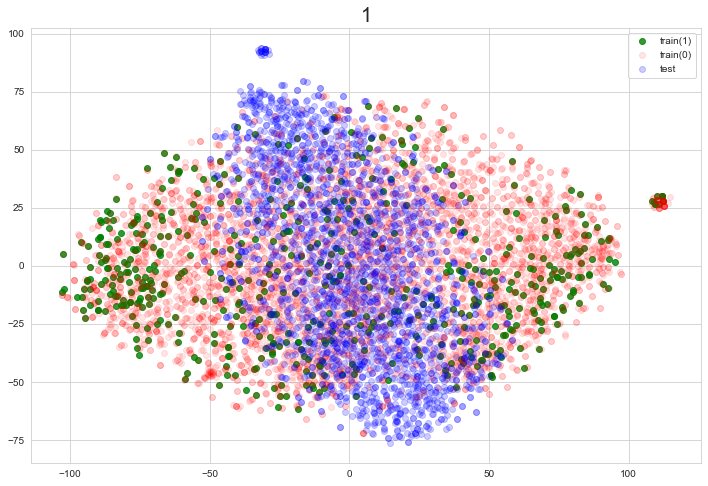

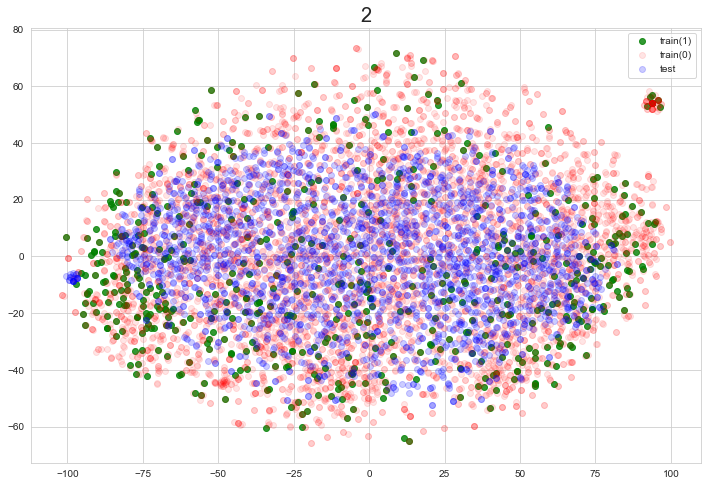

In [ ]:
from sklearn.manifold import TSNE
for n in [1, 2, 3]:
    tsne = TSNE(n_components=2, random_state = SEED)
    X_tr_embedded = tsne.fit_transform(np.around(_x2_tr_c, n))
    X_te_embedded = tsne.fit_transform(np.around(_x2_te_c, n))
    x1 = X_tr_embedded[_y_tr==1]
    x0 = X_tr_embedded[_y_tr!=1]
    
    plt.figure(figsize = (12, 8))
    plt.scatter(x1[:, 0], x1[:, 1], color='green', alpha = .8)
    plt.scatter(x0[:, 0], x0[:, 1], color='red', alpha = .1)
    plt.scatter(X_te_embedded[:, 0], X_te_embedded[:, 1], color='blue', alpha = .2)
    plt.legend(['train(1)', 'train(0)', 'test'])
    plt.title(n, fontsize = 20)
    plt.show()

In [ ]:
_y_tr = y_tr.values
gs = GridSearchCV(logit,\
                  param_grid={'C':np.logspace(-3, 3, 100)},\
                  cv = SKF,\
                  scoring = 'roc_auc',\
                  verbose = 1, n_jobs=-1)
gs.fit(np.around(_x2_tr_c, 2), _y_tr)

In [ ]:
GINI_best_cv = 100*((2 *gs.best_score_)-1)

In [ ]:
GINI_best_cv

In [ ]:
y_predprob = pd.DataFrame(data = gs.best_estimator_.predict_proba(np.around(_x2_te_c, 2))[:, 1],\
             columns = ['predprob'])
y_predprob['ucdb_id'] = X_te.index
y_predprob = y_predprob[['ucdb_id', 'predprob']]

In [ ]:
y_predprob.to_excel('y6_predprob.xlsx')